# Aim

Try to replicate the completeness functions of Ballard (2018) using the catalog of Barclay (2018).

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import optimize, stats, special
import pandas as pd
from tqdm.notebook import tqdm
import emcee
import corner
%matplotlib inline

In [2]:
# constants and frozen parameters, like the bins

Go4pi = 2945.4625385377644/(4 * np.pi * np.pi)
MsoMe_cbrt = 69.31
rng_p = np.array([0.5, 200])
rng_r = np.array([0.5, 4])
num_bins_p = 13
num_bins_r = 17
N1 = 1
sigma1 = 0
N2 = 6.1
sigma2 = 2
fs = 0.55
mixture_params = {"N1": N1, "sigma1": sigma1, "N2": N2, "sigma2": sigma2, "fs": fs}
bins_p = np.exp(np.linspace(*np.log(rng_p), num_bins_p))
bins_r = np.exp(np.linspace(*np.log(rng_r), num_bins_r))

In [3]:
def make_synth_solar_systems(mixture_params=mixture_params, num_stars=10000, mstar=0.4):
    '''
    Makes a synthetic solar system from frozen parameters.
    Follows an empirical distribution, and assumes occurrence is either Pop 1 or Pop 2.
    '''
    rstar = 0.9535 * mstar + 0.0053535 # quick linear fit on the Kepler stellar catalog, filtered on mass bw 0.3 and 0.5 Msuns
    num_pop_1 = int(num_stars * mixture_params['fs'])
    num_pop_2 = num_stars - num_pop_1
    nums_planets = np.empty((0,))
    eccs = np.empty((0,))
    for N, sigma, num_pop in [(mixture_params['N1'], sigma1, num_pop_1), 
                              (mixture_params['N2'], sigma2, num_pop_2)]:
        frac = N % 1
        num_floor = int(num_pop * (1 - frac))
        nums_planets = np.hstack((nums_planets, np.floor(N) * np.ones(num_floor,), np.ceil(N) * np.ones(num_pop - num_floor))).astype(dtype=np.int8)
        # eccs = np.hstack((eccs, stats.rayleigh(scale=sigma, size=num_pop))) # He, Ford, Ragozzine
    ecc_means = 0.584 * np.repeat(nums_planets, nums_planets) ** (-1.2) # Limbach and Turner
    eccs = np.random.rayleigh(np.sqrt(2 / np.pi) * ecc_means)
    num_planets = sum(nums_planets)
    periods = np.exp(np.random.uniform(*np.log(rng_p), size=(num_planets,))) # in days
    prads = np.exp(np.random.uniform(*np.log(rng_r), size=(num_planets,))) # in R_Earths
    pmass = np.maximum(0.8, 2.7 * prads ** 1.3 + np.random.normal(0, 1.9, size=(num_planets,))) # ignoring Zeng/Jacobsen
    system_inds = np.cumsum(nums_planets)
    solar_sys_ids = []
    for i, ind in enumerate(nums_planets):
        solar_sys_ids += [i] * ind
    stabilities = 2 * MsoMe_cbrt * ((periods[1:] ** (2/3) - periods[:-1] ** (2/3)) / (periods[1:] ** (2/3) + periods[:-1] ** (2/3))) * (3 * mstar / (pmass[:-1] + pmass[1:]))
    unstable_inds = np.where(np.logical_and((np.abs(stabilities) <= 2 * np.sqrt(3)), ([x in system_inds for x in range(len(stabilities))])))[0]
    # may need to sort in period order?
    while len(unstable_inds) > 0:
        replace_periods = np.exp(np.random.uniform(*np.log(rng_p), size=(len(unstable_inds),)))
        replace_prads = np.exp(np.random.uniform(*np.log(rng_r), size=(len(unstable_inds),)))
        replace_pmass = 2.7 * replace_prads ** 1.3 + np.random.normal(0, 1.9, size=(len(unstable_inds),)) # ignoring Zeng/Jacobsen
        periods[unstable_inds] = replace_periods
        prads[unstable_inds] = replace_prads
        pmass[unstable_inds] = replace_pmass
        stabilities = 2 * MsoMe_cbrt * ((periods[1:] ** (2/3) - periods[:-1] ** (2/3)) / (periods[1:] ** (2/3) + periods[:-1] ** (2/3))) * (3 * mstar / (pmass[:-1] + pmass[1:]))
        unstable_inds = np.where(np.logical_and((np.abs(stabilities) <= 2 * np.sqrt(3)), ([x in system_inds for x in range(len(stabilities))])))[0]
    a = (Go4pi * periods * periods * mstar) ** (1./3)
    transit_bool = a / rstar * (1 - eccs ** 2) <= 1
    ttv = np.random.binomial(n = 1, p = [{1: 0.035, 2: 0.07, 3: 0.08}.get(x) if x < 4 else 0.104 for x in np.repeat(nums_planets, nums_planets)], size=(num_planets,))
    # densities = (stabilities / 22) ** 6 #size mismatch
    return pd.DataFrame({
                        "ids" : solar_sys_ids,
                        "periods" : periods, 
                         "prads" : prads, 
                         "pmass" : pmass, 
                         "eccs" : eccs,
                         "a" : a, 
                         "transit_bool" : transit_bool,
                         "ttv" : ttv, 
                        })

In [19]:
# downloaded from http://vizier.u-strasbg.fr/viz-bin/VizieR?-source=J/ApJ/809/77
cut_to_Ms = True
barclay_catalog = pd.read_csv('barclay_data/detected_planets.csv', skiprows=42)
if cut_to_Ms:
    barclay_catalog = barclay_catalog[barclay_catalog["Star-teff"] <= 3700]
num_stars = len(barclay_catalog)
synth_solsys = make_synth_solar_systems(num_stars=num_stars)
print("Selected {} stars".format(num_stars))

Selected 415 stars


Text(0.5, 1.0, "Ballard's initial distribution of injected planets")

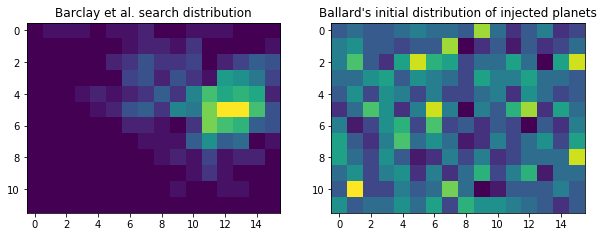

In [20]:
hist2d_ballard = np.histogram2d(synth_solsys.periods, synth_solsys.prads, bins=[bins_p, bins_r])
hist2d_barclay = np.histogram2d(barclay_catalog['Planet-period'], barclay_catalog['Planet-radius'], bins=[bins_p, bins_r])
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
ax1.imshow(hist2d_barclay[0])
ax1.set_title("Barclay et al. search distribution")
ax2.imshow(hist2d_ballard[0])
ax2.set_title("Ballard's initial distribution of injected planets")

In [21]:
D = hist2d_barclay[0]
N = hist2d_ballard[0]
fact_D = special.gamma(D + 1)
log_fact_D = special.gammaln(D + 1)
fail_ll = -1e10 or -np.inf 

comp_poly = lambda x, a1, a2, a3, a4: a4 + a1 * x + (a1 * a2) * x ** 2 + (a1/3) * (a2**2 + a3**2) * x ** 3

def ll(a):
    a_period, a_radius = a[:4], a[4:]
    comp_p, comp_r = comp_poly(bins_p[:-1], *a_period), comp_poly(bins_r[:-1], *a_radius)
    has_negative = np.any(comp_p < 0) or np.any(comp_r < 0)
    if has_negative:
        return -np.inf
    comp = np.outer(comp_p, comp_r)
    if np.any(comp < 0):
        return -np.inf
    mu = N * comp
    if np.any(mu <= 0):
        return -np.inf
    # likelihood_mat = mu ** D * np.exp(-mu) / fact_D
    # return np.nansum(np.log(likelihood_mat))
    ll_mat = D * np.log(mu) - mu - log_fact_D
    return np.sum(ll_mat)

ndim = 8
nwalkers = 24
optimize_result = optimize.minimize(lambda x: -ll(x), [1, 0, 0, 0, 1, 0, 0, 0], method='Nelder-Mead', options={"maxiter" :10000})
leastsq_sol = optimize_result.x

def prior(a):
    return np.all(np.isfinite(a)) and np.all(np.abs(leastsq_sol - a) < 100)

def ll_with_prior(a):
    if not prior(a):
        return -np.inf
    return ll(a)

sampler = emcee.EnsembleSampler(nwalkers, ndim, ll_with_prior)
p0 = leastsq_sol + np.random.normal(0, 1e-3, size=(nwalkers, ndim))

_ = sampler.run_mcmc(p0, 100, progress="notebook")
sampler.reset()
pos, _, _ = sampler.run_mcmc(p0, 20000, store=True, progress="notebook")


/Users/adityasengupta/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


In [29]:
leastsq_sol #+ np.random.normal(0, 1e-3, size=8)

array([ 1.61783325e+00, -1.44643518e-02,  1.34262559e-05, -1.91125390e-02,
        1.58869997e-02,  1.13711388e-02,  5.00871473e-03, -7.98876474e-03])

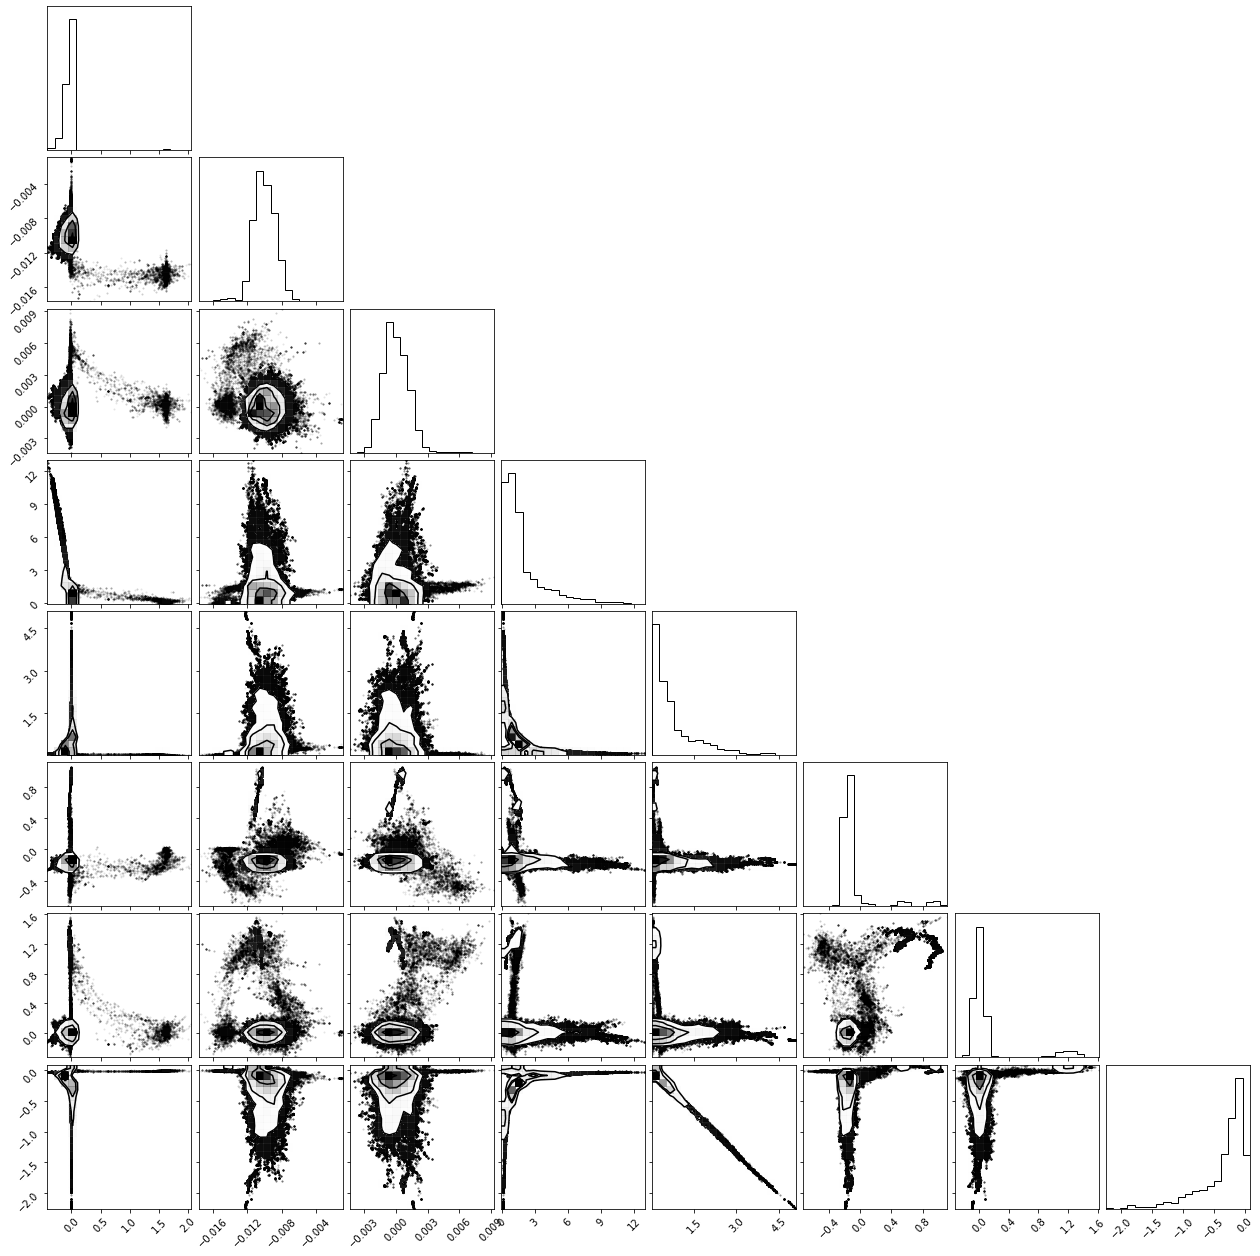

In [22]:
_ = corner.corner(sampler.flatchain)

In [13]:
pos, _, _ = sampler.run_mcmc(p0, 20000, store=True, progress="notebook")

/Users/adityasengupta/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


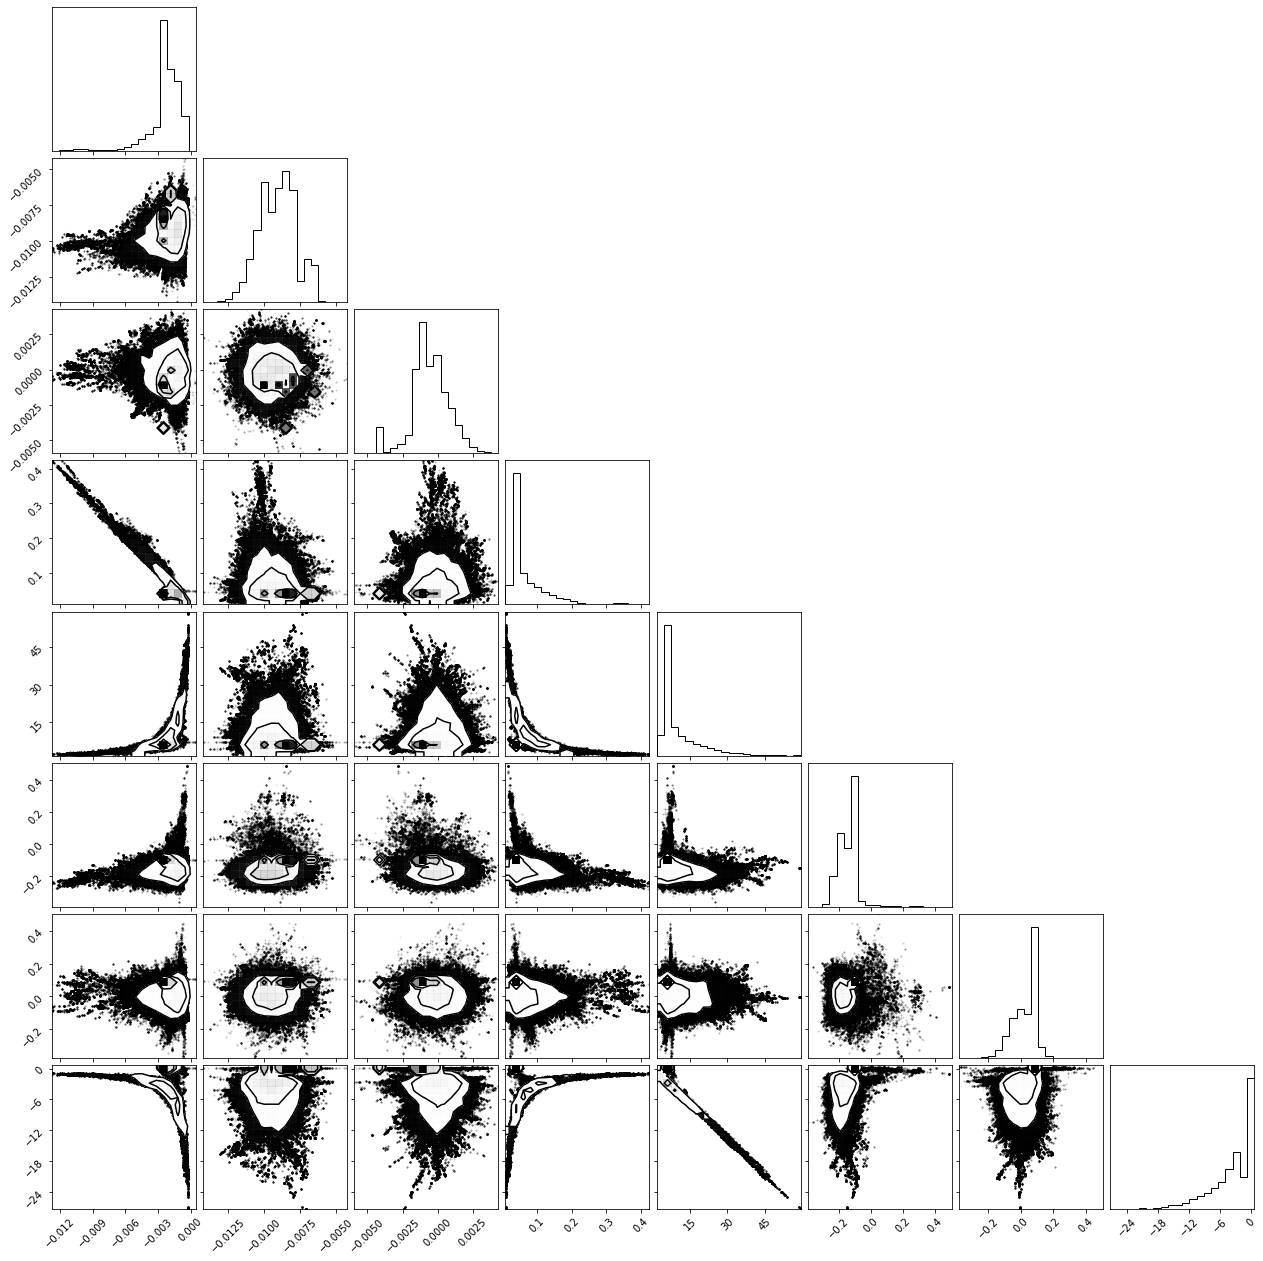

In [14]:
_ = corner.corner(sampler.flatchain)

In [15]:
params = np.mean(pos, axis=0)
params

array([-2.67783394e-03, -9.05445428e-03, -7.02152575e-04,  8.31728059e-02,
        1.32640962e+01, -1.55528909e-01,  3.73837895e-02, -4.92886947e+00])

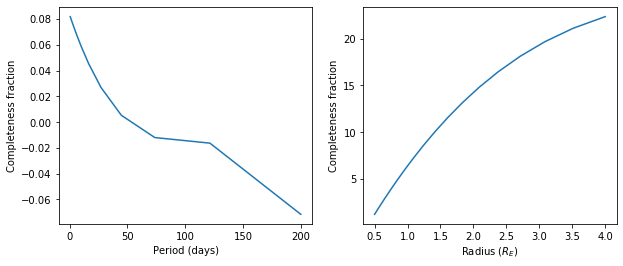

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.plot(bins_p, comp_poly(bins_p, *params[:4]))
ax1.set_xlabel("Period (days)")
ax1.set_ylabel("Completeness fraction")
ax2.plot(bins_r, comp_poly(bins_r, *params[4:]))
ax2.set_xlabel(r"Radius ($R_E$)")
ax2.set_ylabel("Completeness fraction")
plt.show()

Text(0.5, 1.0, 'Replicated completeness')

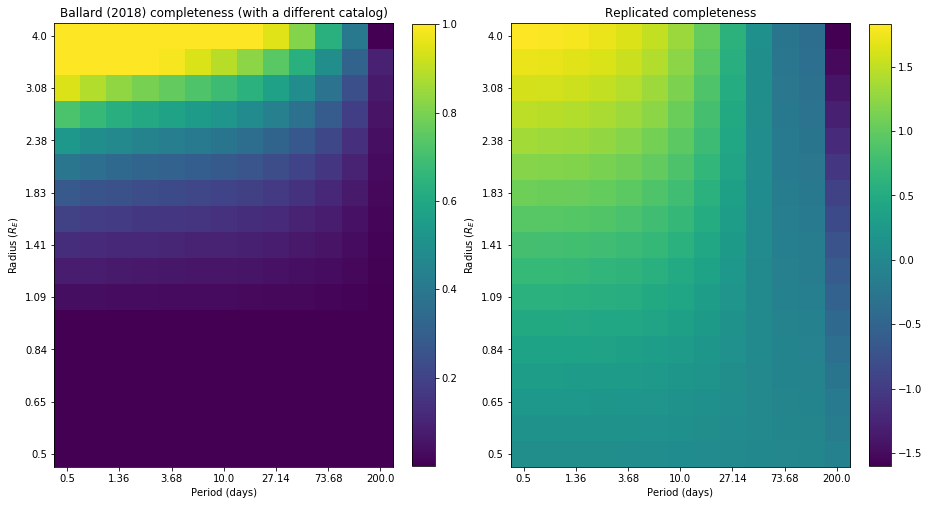

In [17]:
comp04m = np.load('ballard_data/Completeness_0.4Msun.npy')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,12))
ballard_comp = ax1.imshow(comp04m[-1], origin='lower')
fig.colorbar(ballard_comp, ax=ax1, fraction=0.058)
ax1.set_xticks(np.arange(13)[::2])
ax1.set_xticklabels(np.round(bins_p[::2], 2))
ax1.set_xlabel("Period (days)")
ax1.set_yticks(np.arange(17)[::2])
ax1.set_yticklabels(np.round(bins_r[::2], 2))
ax1.set_ylabel(r"Radius ($R_E$)")
ax1.set_title("Ballard (2018) completeness (with a different catalog)")
self_comp = ax2.imshow(np.outer(comp_poly(bins_p, *params[:4]), comp_poly(bins_r, *params[4:])).T, origin='lower')
fig.colorbar(self_comp, ax=ax2, fraction=0.058)
ax2.set_xticks(np.arange(13)[::2])
ax2.set_xticklabels(np.round(bins_p[::2], 2))
ax2.set_xlabel("Period (days)")
ax2.set_yticks(np.arange(17)[::2])
ax2.set_yticklabels(np.round(bins_r[::2], 2))
ax2.set_ylabel(r"Radius ($R_E$)")
ax2.set_title("Replicated completeness")